# Level 1 — Subpopulation Discovery in Bladder Cancer Proteomics



This notebook identifies patterns in a bladder cancer proteomics dataset using unsupervised learning.

Course: Omics for Non-Biologists
Group name: Genomics

Group members:

- Ke Wang
- Carla Malo
- Marc Nanzer
- Jiayi Ma
- Choekyel Nyungmartsang

Expected input files

- ../data/proteomics.txt (required): protein abundance matrix
- ../data/metadata.csv (optional): clinical metadata
- ./src/ (required): helper functions used in this notebook

Dataset

- 140 patients
- 3,120 proteins
- Each value represents the measured abundance of one protein in one patient

Level 1 goal

- Build an unsupervised pipeline to group patients into clusters based on their protein profiles
- Justify the number of clusters using quantitative metrics and visual evidence

Planned approach

- Reduce dimensionality using PCA
- Apply KMeans clustering in the reduced space
- Evaluate clustering using elbow analysis, silhouette scores, gap statistic and 2D visualizations (PCA and UMAP)

## 0. Imports & Global Settings
Set random seeds and plotting style for reproducibility.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For gap plot
from sklearn.cluster import KMeans  # For gap statistic

from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.preprocessing import (
    log2_transform,
    median_center_rows,
    zscore_normalize,
)

from src.bladder_proteomics.dimensionality_reduction import apply_pca, apply_umap
from src.bladder_proteomics.k_selection import evaluate_k_selection_one, gap_statistic
from src.bladder_proteomics.clustering import kmeans_cluster
from src.bladder_proteomics.plotting import (
    set_plot_style,
    plot_pca,
    plot_umap,
    plot_cluster_sizes,
)

np.random.seed(42)
set_plot_style(dpi=120)


## 1. Load & Align Proteomics and Metadata
Load proteomics and clinical metadata, and align them by Patient ID.


In [2]:
proteomics, metadata = load_data(
    "../data/proteomics.txt",
    "../data/metadata.csv",
    transpose=True
)

validate_data(proteomics)
validate_data(metadata)

# Align by Patient ID
common_ids = proteomics.index.intersection(metadata.index)
proteomics = proteomics.loc[common_ids]
metadata = metadata.loc[common_ids]

print(f"Number of patients after alignment: {len(common_ids)}")


Removed proteins with identical profiles: 9
Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Data shape (samples × features): (140, 13)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Number of patients after alignment: 140


## 2. Feature selection

### 2.1 Pipeline helper functions

Main design elements:
- In the top-protein (*m*) selection, log2-transform is applied to the variance to stabilize and reduce skewness in the proteins, while also preserving the biological meaning.
- PCA before clustering is done to reduce noise, collinearity and dimensionality. 
- For each number of principal components (*n_pc*), multiple clusters (*k*) were computed and evaluated across different metrics (elbow, silhouette, gap statistic) to identify consistent solutions.


In [ ]:
def select_representative_npc(
    pca_df: pd.DataFrame,
    pc_grid,
    k_max=20,
    gap_B=50,
    random_state=42,
):
    """ Select representative number of PCs and k based on the metrics (elbow, silhouette, gap statistic).
    Args:
        pca_df: DataFrame with PCA components.
        pc_grid: List of number of PCs to evaluate.
        k_max: Maximum number of clusters to evaluate.
        gap_B: Number of bootstrap samples for gap statistic.
        random_state: Random seed for reproducibility.
    Returns:
        best_row: Series with best configuration or None if no consistent result.
        df: DataFrame with all evaluated configurations."""
    records = []

    # Evaluate over grid of n_pc and k
    for npc in pc_grid:
        X = pca_df.iloc[:, :npc].values
        # Evaluate k selection methods (elbow, silhouette)
        res = evaluate_k_selection_one(pd.DataFrame(X), k_max=k_max)

        # Evaluate k selection (gap statistic)
        gap, se, wk, gap_k = gap_statistic(
            X,
            k_max=k_max,
            B=gap_B,
            random_state=random_state,
        )

        records.append({
            "n_pc": npc,
            "elbow_k": res["elbow_k"],
            "best_k": res["best_k_sil"],
            "best_sil": res["best_sil"],
            "gap_k": gap_k,
            "gap_at_k": float(gap[gap_k - 1]),
        })

    df = pd.DataFrame(records)
    
    # Stable selection: consistent optimal k across methods (elbow, silhouette, gap statistic)
    consistent = df[(df["elbow_k"] == df["best_k"]) & (df["best_k"] == df["gap_k"])]

    if consistent.empty:
        return None, df
    # Store ONLY stable selection
    best_row = consistent.loc[consistent["best_sil"].idxmax()]
    return best_row, df


def select_top_m(X: pd.DataFrame, m: int) -> pd.DataFrame:
    """ Select top m features by variance after log2 transformation.
    Args:
        X: DataFrame with features.
        m: Number of top features to select.
    Returns:
        DataFrame with top m features."""   
    X_log, _ = log2_transform(X) # To stabilize variance and reduce skewness
    var = X_log.var(axis=0)
    top_features = var.sort_values(ascending=False).head(m).index
    return X_log[top_features]


### 2.2 Pipeline Workflow

Summary of the workflow for feature selection: 

1. Feature Preselection (Reduce noise and dimensionality)
    - Log2-transform protein abundances
    - Select top m proteins by variance per patient.

2. Normalization (z-score normalization per protein)
3. PCA (Dimensionality Reduction for noise reduction, visualization, clustering space)
    - PCA fitted once per m
    - Retain up to n_max (20) components
4. Joint Search over (n_pc and k) within this fixed PCA space
    - Perform clustering (K Means)
    - Evaluate cluster quality using (elbow method, silhouette score, gap spatistic)
5. Stability-Constrained Model Selection
    - Select only the stable solution (n_pc, k). These are defined only if (Elbow k == Silhouette k == Gap k).
    - Among stable solutions, choose the one with highest silhouette score.



In [ ]:
m_grid = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] # top m protein hyperparameter grid
n_max = 20 # max. number of PCs
k_results = []

for m in m_grid:
    # 1. Apply log transform and select top m features by variance
    X_m = select_top_m(proteomics, m)
    # 2. Normalize per protein
    X_m_scaled = zscore_normalize(X_m, axis=0)
    # 3. PCA
    pca_nmax = min(n_max, X_m_scaled.shape[1])
    pca_full, pca_model = apply_pca(
        X_m_scaled,
        n_components=pca_nmax,
        return_model=True
    )

    # 4. Joint Search over n_pc and k in fixed PCA space
    pc_grid = list(range(2, pca_nmax + 1))
    k_max = pca_nmax

    best_row, df_npc = select_representative_npc(
        pca_full,
        pc_grid=pc_grid,
        k_max=k_max,
        gap_B=50,
        random_state=42
    )

    if best_row is None:
        k_results.append({
            "m": m,
            "status": "unstable",
        })
        continue
    # Store results
    explained = pca_model.explained_variance_ratio_
    var_explained_npc = explained[:int(best_row["n_pc"])].sum()

    k_results.append({
        "m": m,
        "n_pc": best_row["n_pc"],
        "k": best_row["best_k"],
        "best_sil": best_row["best_sil"],
        "gap_k": best_row["gap_k"],
        "gap_at_k": best_row["gap_at_k"],
        "var_explained": var_explained_npc,
        "status": "stable",
    })

k_summary = pd.DataFrame(k_results)
k_summary


c:\Users\carla\.conda\envs\omics-dev\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,m,status,n_pc,k,best_sil,gap_k,gap_at_k,var_explained
0,5,unstable,NaN,NaN,NaN,NaN,NaN,NaN
1,10,unstable,NaN,NaN,NaN,NaN,NaN,NaN
2,15,unstable,NaN,NaN,NaN,NaN,NaN,NaN
3,20,stable,6.0,7.0,0.896390,7.0,931.879545,0.989139
4,25,stable,6.0,7.0,0.846189,7.0,1284.692405,0.961663
5,30,unstable,NaN,NaN,NaN,NaN,NaN,NaN
6,35,unstable,NaN,NaN,NaN,NaN,NaN,NaN
7,40,unstable,NaN,NaN,NaN,NaN,NaN,NaN
8,45,unstable,NaN,NaN,NaN,NaN,NaN,NaN
9,50,unstable,NaN,NaN,NaN,NaN,NaN,NaN


### 2.3 Criteria selection for final *m* and *k*
For the selection of the final *m* and *k*, we selected the configuration that was
**stable, with a high explained variance (higher than 80%) and with the highest silhouette score**.

For a solution to be considered stable it had to agree on the number of clusters across all tree methods (elbow, silhouette and gap statistic). **This approach ensured robust and non-random subpopulation identification**.


In [5]:
# keep only stable rows
stable_df = k_summary[
    (k_summary["status"] == "stable") &
    (k_summary["var_explained"] >= 0.8)
].copy()

# select the row with maximum silhouette
best_final = stable_df.loc[stable_df["best_sil"].idxmax()]

best_final


m                        20
status               stable
n_pc                    6.0
k                       7.0
best_sil            0.89639
gap_k                   7.0
gap_at_k         931.879545
var_explained      0.989139
Name: 3, dtype: object

## 3. Visualization



### 3.1 Reconstruction of data

In [ ]:
m_star = int(best_final["m"])
n_pc_star = int(best_final["n_pc"])
k_star = int(best_final["k"])

# feature selection
X_m = select_top_m(proteomics, m_star)
X_m_scaled = zscore_normalize(X_m, axis=0)

# PCA fit to fixed 20 (same rule as before)
pca_nmax = min(n_max, X_m_scaled.shape[1])
pca_full, pca_model = apply_pca(
    X_m_scaled,
    n_components=pca_nmax,
    return_model=True
)

# clustering space
X_cluster = pca_full.iloc[:, :n_pc_star]

labels = kmeans_cluster(
    X_cluster,
    n_clusters=k_star,
    align_labels=True
)


### 3.1.1 Gap Statistic Plot
Visual check for the optimal k based on the selected PCA space.


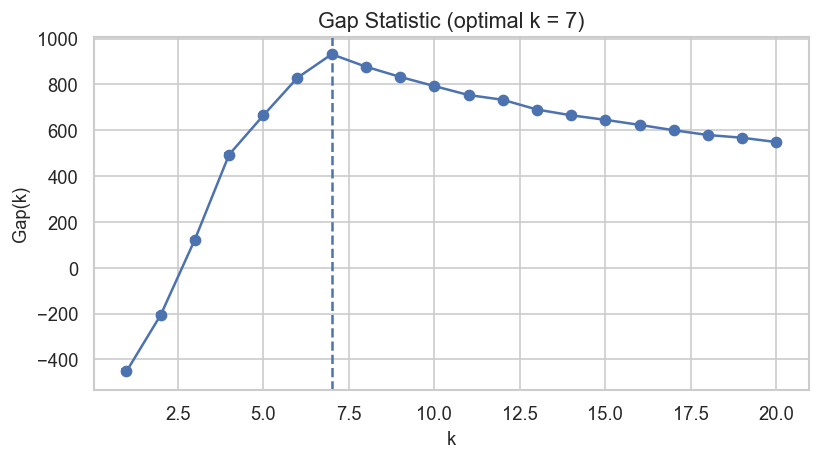

In [7]:
# Gap statistic plot for the selected PCA space
gap, se, wk, k_opt = gap_statistic(X_cluster.values, k_max=pca_nmax, B=50, random_state=42)

ks = np.arange(1, len(gap) + 1)
plt.figure(figsize=(7, 4))
plt.errorbar(ks, gap, yerr=se, marker='o', capsize=3)
plt.axvline(k_opt, linestyle='--')
plt.xlabel("k")
plt.ylabel("Gap(k)")
plt.title(f"Gap Statistic (optimal k = {k_opt})")
plt.grid(True)
plt.tight_layout()
plt.show()


### 3.2 PCA plot

(<Figure size 720x720 with 1 Axes>,
 <Axes: title={'center': 'PCA (m=20, n_pc=6, k=7)'}, xlabel='PC1', ylabel='PC2'>)

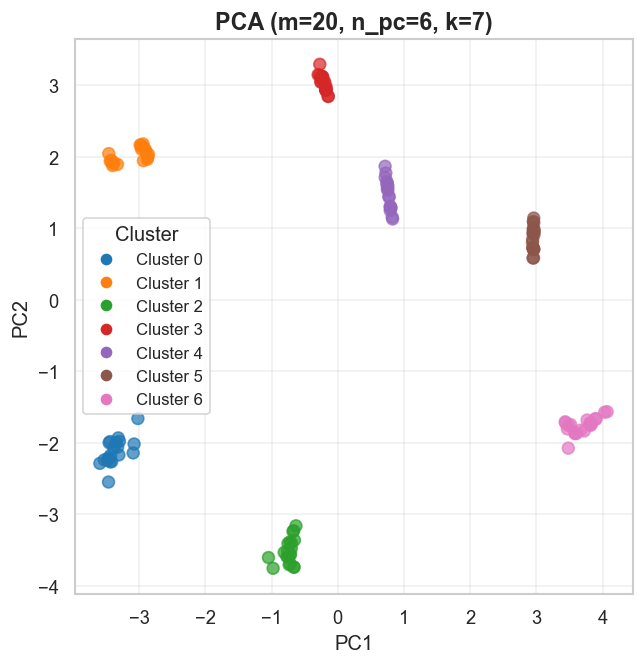

In [8]:
plot_pca(
    pca_full.iloc[:, :2],
    labels=labels,
    title=f"PCA (m={m_star}, n_pc={n_pc_star}, k={k_star})",
    figsize=(6, 6)
)


### 3.3 UMAP plot

c:\Users\carla\.conda\envs\omics-dev\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(<Figure size 720x720 with 1 Axes>,
 <Axes: title={'center': 'UMAP (m=20, n_pc=6, k=7)'}, xlabel='UMAP1', ylabel='UMAP2'>)

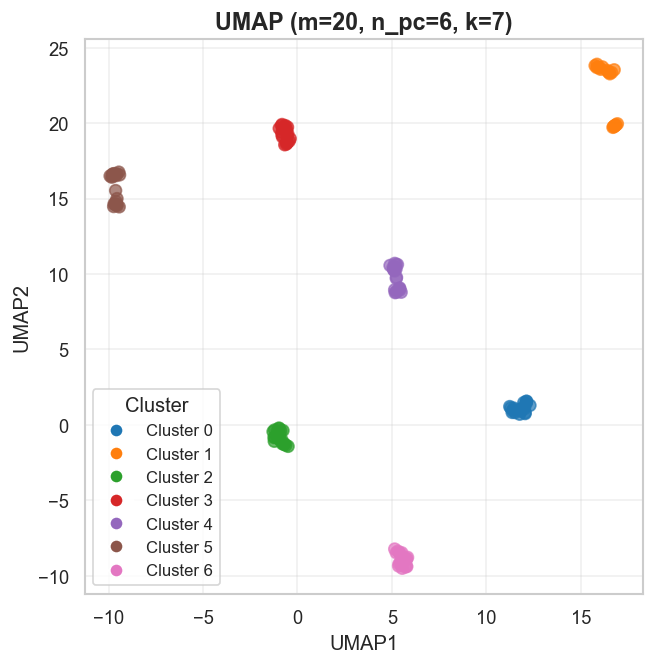

In [9]:
umap_2d = apply_umap(
    X_cluster,
    n_components=2,
    random_state=42
)


plot_umap(
    umap_2d,
    labels=labels,
    title=f"UMAP (m={m_star}, n_pc={n_pc_star}, k={k_star})",
    figsize=(6, 6),
)



### 3.4 Cluster Size Distribution

<Axes: title={'center': 'Cluster size distribution'}, xlabel='Number of patients'>

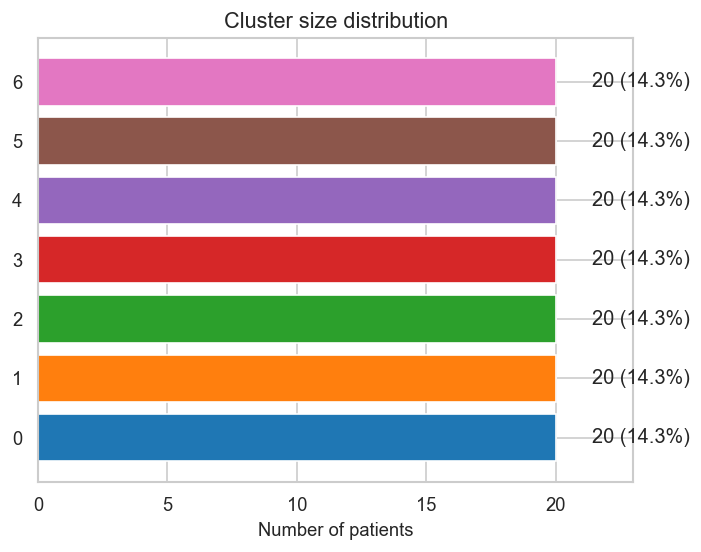

In [10]:
plot_cluster_sizes(
    pd.Series(labels, index=X_cluster.index),
    title="Cluster size distribution",
)


## 5. Metadata Evaluation
This is not a new clustering, just for evaluation or possible interpretation.

### 5.1 Alignment

In [11]:
metadata_aligned = metadata.loc[X_cluster.index].copy()
metadata_aligned["Cluster"] = labels

### 5.2 Numerical Metadata (Age, Tumor_Size etc.)

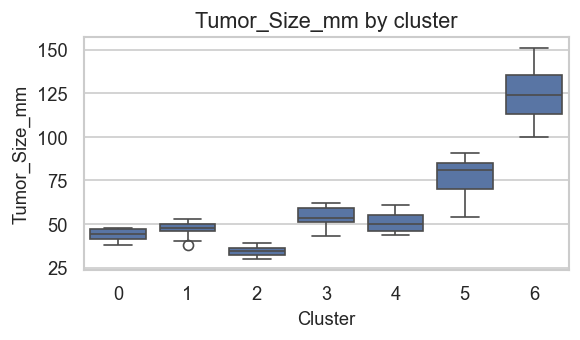

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["Tumor_Size_mm"]
#  "Age", "Follow_up_Duration_months" seems non-relevant

for col in num_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(
        data=metadata_aligned,
        x="Cluster",
        y=col
    )
    plt.title(f"{col} by cluster")
    plt.tight_layout()
    plt.show()


- There is a clear correlation between cluster and tumor size. 

Why clusters are sorted by tumor size for the tasks below? 

- Clusters are ordered by increasing median tumor size to impose a clinically interpretable progression axis, allowing systematic comparison of survival and treatment response patterns across clusters.

In [13]:
cluster_order = (
    metadata_aligned
    .groupby("Cluster")["Tumor_Size_mm"]
    .median()
    .sort_values()
    .index
    .tolist()
)

cluster_order


[2, 0, 1, 4, 3, 5, 6]

### 5.3 Categorical Metadata Histological_Grade, Metastasis, Survival etc.）

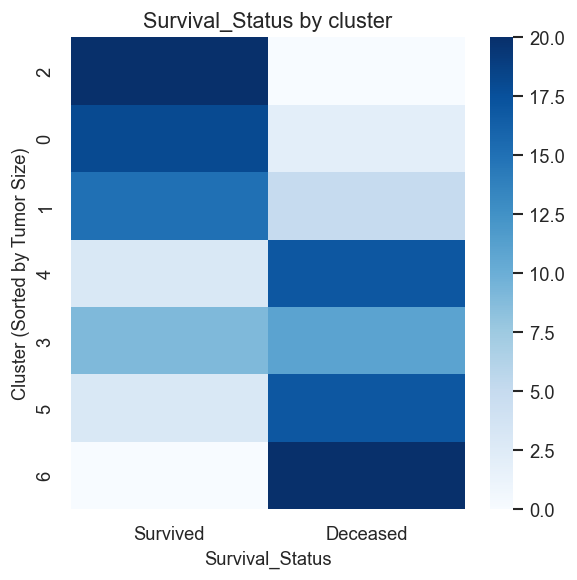

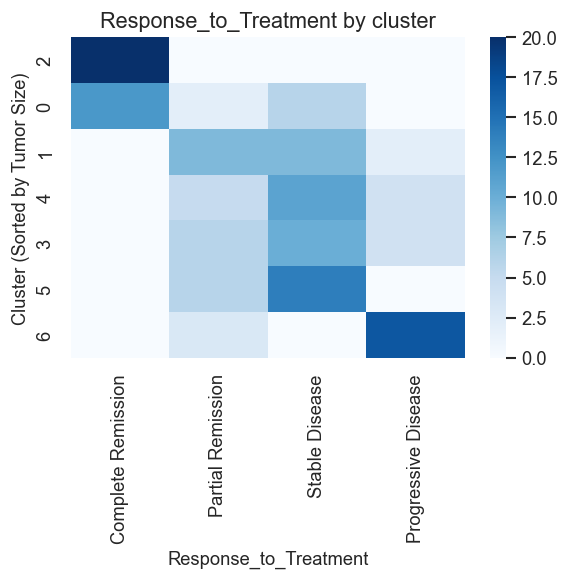

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


cat_cols = [
    
    "Survival_Status",
    "Response_to_Treatment",
    
]
# "Histological_Grade", seems not very relevant
# "Metastasis", seems not very relevant
# "Treatment", seems not very relevant
# "Lymph_Node_Involvement", seems not very relevant

for col in cat_cols:
    ct = pd.crosstab(metadata_aligned["Cluster"], metadata_aligned[col])
    # display(ct)
    ct = ct.loc[cluster_order]
    if col=="Survival_Status":  
        ct = ct[["Survived", "Deceased"]]
    if col=="Response_to_Treatment":  
        ct = ct[["Complete Remission", "Partial Remission", "Stable Disease", "Progressive Disease"]]


    plt.figure(figsize=(5, 5))
    sns.heatmap(
        ct,
        cmap="Blues",
        fmt=".2f"
    )
    plt.title(f"{col} by cluster")
    plt.ylabel("Cluster (Sorted by Tumor Size)")
    plt.xlabel(f"{col}")
    plt.tight_layout()
    plt.show()



#### Qualitative interpretation of the Metadata vs cluster

The survival heatmap shows a clear shift from predominantly survived patients in small-tumor clusters to predominantly deceased patients in large-tumor clusters, indicating strong clinical stratification by cluster.

The treatment-response heatmap reveals a parallel trend, with early clusters enriched for complete or partial remission and later clusters dominated by stable or progressive disease, supporting the clinical relevance of the identified subpopulations.
